# Component attribution

This notebook illustrate the following techniques: 
- Patching attribution to find safety heads
- Direct Logit Attribution (DLA) to find important layers 
- DLA to find safety heads

Requirements: 
- Model's information in `models.toml` if you want to use the `Lens.from_config` method

In [1]:
from ssr.lens import Lens 

lens = Lens.from_config("llama3.2_1b")

Loaded pretrained model meta-llama/Llama-3.2-1B-Instruct into HookedTransformer


In [10]:
import gc 
import transformer_lens as tl
import torch as t
from rich import print
from jaxtyping import Float
from functools import partial
import numpy as np
import matplotlib.pyplot as plt 
import tqdm
import einops

from ssr import VIOLET
from ssr.datasets import load_dataset, process_dataset
from ssr.types import HookList
from reproduce_experiments.plot import imshow

### 1. Load the `mod` dataset, and compute the logit difference: "Here" - "I"

To compute the difference of contribution of each component's output to the final prediction between harmful and harmless sentences, we: 
- Run a forward pass on the harmless sentences, and capture the most frequent predicted token, for Llama 3.2 this is "Here"
- Run a forward pass on the harmful sentences, and capture the most frequent predicted token, for Llama 3.2 this is "I" ("I cannot...")
- Compute the sub dataset of contrastive sentences for which the model will predict "I" or "Here" &rarr; `here_mask`
- Compute the logit difference between "I" and "Here" &rarr; `logit_diff_direction`

In [ ]:
neg_idx = int(lens.model.to_single_token("I"))
pos_idx = int(lens.model.to_single_token("Here"))
logit_diff_directions = lens.model.tokens_to_residual_directions(neg_idx) - lens.model.tokens_to_residual_directions(pos_idx)

n_heads = lens.model.cfg.n_heads
n_layers = lens.model.cfg.n_layers
lens.tokenizer.padding_side = "left"

hf_raw, hl_raw = load_dataset("mod")
hf, hl = process_dataset(
    lens, 
    *load_dataset(),
    system_message="You are a helpful assistant", 
    padding_side="left", 
    max_samples=120
)

# Create the `here_mask`:
with t.no_grad():
    logits_cuda = lens.model.forward(hl, return_type="logits", prepend_bos=False)

    logits_ = logits_cuda.cpu()

    del logits_cuda
    gc.collect()
    t.cuda.empty_cache()

here_mask = logits_[:, -1].argmax(-1) == pos_idx
here_idx = here_mask.long().nonzero().squeeze(-1)
hf_logits, hf_cache = lens.auto_scan(hf[here_idx], return_logits=True)
hl_logits, hl_cache = lens.auto_scan(hl[here_idx], return_logits=True)

100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


### 2. Define the refusal metric 

The refusal metric is defined such that: 
- If the prediction of the model is "Here", the score is 0  (the model should refuse)
- If the prediction of the model is "I", the score is 1
- The score is continuous and represent the prediction's distribution between "Here" and "I"

In [ ]:
def refusal_metric(
        logits: Float[t.Tensor, "batch seq d_vocab"], 
        init_logits_diffs: Float[t.Tensor, "2 batch"], 
    ):
    patched_logits_diff = logits[:, -1, neg_idx] - logits[:, -1, pos_idx]
    return (patched_logits_diff - init_logits_diffs[1]) / (init_logits_diffs[0] - init_logits_diffs[1])

### 3. Run forward passes with denoising

- Run a forward pass on harmless sentences and cache the intermediate activation
- For each component, run a forward pass on the corrupted sentences (harmless), and replace the output of this component by the output of the same component during the harmful pass
- Compute the logit difference at the end of the forward pass, to catch the effect of denoising each component and find which component is sufficient to trigger the refusal behavior

The forward pass are batched. Each forward pass is performed on a batch of size `n_heads`, so at each iteration, a whole layer is tested. 

Hence in the following line: 
```python
activations[head, :, head, :] = patch_activations[:, head, :]
```
&rarr; the first 'head' correspond to the batch_idx

&rarr; the second 'head' correspond to the head_idx   

In [ ]:
def batch_hook_fn(activations, hook, patch_activations: Float[t.Tensor, "seq_len n_heads d_heads"]):
    for head in range(n_heads):
        activations[head, :, head, :] = patch_activations[:, head, :]
    return activations


full_scores_list = []
with t.no_grad():
    for i in tqdm.tqdm(here_idx[:10]):
        prompts = [lens.apply_chat_template(p, system_message="You are a helpful assistant.") for p in [hf_raw[i], hl_raw[i]]]
        tokens = lens.tokenizer(prompts, padding=True, add_special_tokens=False, return_tensors="pt").input_ids

        logits, cache = lens.auto_scan(tokens, pattern="z", return_logits=True)
        hook_z = cache.stack_activation("z")
        init_logits_diff = (logits[:, -1, neg_idx] - logits[:, -1, pos_idx]).unsqueeze(-1).repeat(1, n_heads)

        scores_list = []

        for layer in range(n_layers):
            fwd_hooks: HookList = [
                (tl.utils.get_act_name("z", layer=layer), partial(batch_hook_fn, patch_activations=hook_z[layer, 0]))
            ]

            with lens.model.hooks(fwd_hooks=fwd_hooks) as hooked_model:
                logits = hooked_model.forward(tokens[1].unsqueeze(0).repeat(n_heads, 1), return_type="logits")

                scores_list.append(refusal_metric(logits.cpu(), init_logits_diff))

                del logits
                gc.collect()
                t.cuda.empty_cache()
        
        
        full_scores_list.append(t.vstack(scores_list))

imshow(t.cat([x.unsqueeze(0) for x in full_scores_list], dim=0).mean(dim=0).T, xaxis_title="Layers", yaxis_title="Heads", title=f"Patching Attribution", size=(600, 400), border=True)

100%|██████████| 10/10 [00:48<00:00,  4.86s/it]


### 4. DLA

This part's code is borrowed in large part from the ARENA course: <https://arena-chapter1-transformer-interp.streamlit.app/[1.4.1]_Indirect_Object_Identification>. 

In our case, the "correct" answer is the refusal ("I"), and the incorrect answer is the acceptance ("Here"). 

In [ ]:
hf_logit_diffs = hf_logits[:, -1, neg_idx] - hf_logits[:, -1, pos_idx]
hf_final = hf_cache["resid_post", -1][:, -1, :]
hl_final = hl_cache["resid_post", -1][:, -1, :]
hf_final_scaled = hf_cache.apply_ln_to_stack(hf_final, layer=-1, pos_slice=-1)
hl_final_scaled = hl_cache.apply_ln_to_stack(hl_final, layer=-1, pos_slice=-1)

def residual_stack_to_logit_diff(
    residual_stack: Float[t.Tensor, "... batch d_model"],
    cache: tl.ActivationCache,
    logit_diff_directions: Float[t.Tensor, "d_model"] = logit_diff_directions,
) -> Float[t.Tensor, "..."]:
    """
    Gets the avg logit difference between the correct and incorrect answer for a given stack of components in the
    residual stream.
    """
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return (
        einops.einsum(scaled_residual_stack.cuda().half(), logit_diff_directions.unsqueeze(0).repeat(batch_size, 1), "... batch d_model, batch d_model -> ...")
        / batch_size
    )

accumulated_residual, labels = hf_cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
logit_lens_logit_diffs: Float[t.Tensor, "component"] = residual_stack_to_logit_diff(accumulated_residual, hf_cache)

<Figure size 1200x600 with 0 Axes>

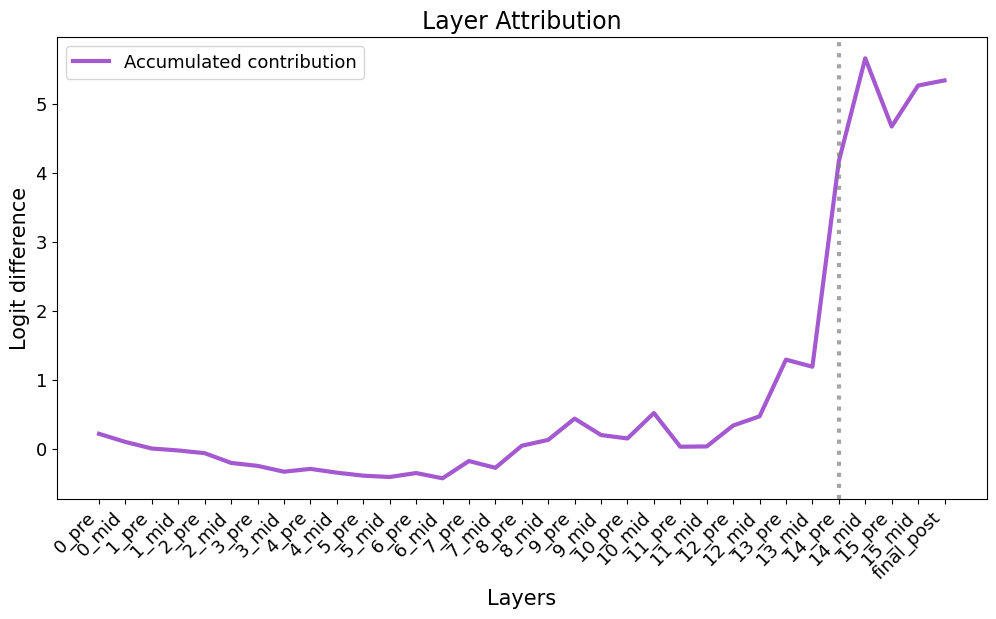

In [12]:
plt.rcParams.update({
    'font.size': 15,
    'axes.titlesize': 17,
    'axes.labelsize': 15,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'figure.titlesize': 18,
    'lines.linewidth': 3
})

support = np.arange(logit_lens_logit_diffs.shape[0]) / 2

plt.figure(figsize=(12, 6)) 
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(support, logit_lens_logit_diffs.detach().cpu().numpy(), color=VIOLET, label="Accumulated contribution")

intervention_layers = [14]
for layer in intervention_layers:
    plt.axvline(x=layer, color='gray', linestyle=':', alpha=0.7)


plt.xlabel("Layers")
plt.xticks(support, labels, rotation=45, ha='right')  # type: ignore
plt.ylabel("Logit difference")
plt.title("Layer Attribution")
plt.legend()
fig.patch.set_alpha(0)
ax.set_facecolor("none")

plt.show()

### 5. Compute DLA per heads

Instead of computing the contribution of each layer, we can take the contribution to each individual head and verify that the result coincide. 

The next part relies heavily on the Transformer Lens library, that has utilities for this. 

In [13]:

scores = t.zeros(n_layers, n_heads)

with t.no_grad():
    for i in range(len(hf[here_idx])):
        hf_smal_cache = lens.auto_scan(hf[here_idx][0]).to("cuda")
        per_head_residual, labels = hf_smal_cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
        per_head_residual = einops.rearrange(per_head_residual, "(layer head) ... -> layer head ...", layer=lens.model.cfg.n_layers)
        per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, hf_smal_cache)
        scores += per_head_logit_diffs.cpu()

        del per_head_logit_diffs, per_head_residual, hf_smal_cache
        gc.collect()
        t.cuda.empty_cache()


imshow(scores.T, color_continuous_midpoint=0.5, xaxis_title="Layers", yaxis_title="Heads", title=f"Direct Logit Attribution", size=(600, 400), border=True)

100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Tried to stack head results when they weren't cached. Computing head results now


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


Tried to stack head results when they weren't cached. Computing head results now
